## Acoustic Signal Processing for Bioacoustics
### 06 - Linear Predictive Coding (LPC)

In this notebook, we'll use LPC - a tool commonly used for speech analysis/synthesis - for analysis of animal vocalizations. 


Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)


Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [2]:
import numpy as np 
import scipy as sp
from scipy import signal 
import sounddevice as sd
import soundfile as sf
# import acoustics as ac # We use this for the noise generators: https://github.com/python-acoustics/python-acoustics/tree/master
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl


### Introduction

Linear Prediction (LP) models predict/forecast future values of a signal from linear combination of past values. It can also be understood from the point of view of a source-filter representation (see following section), where all-pole filters model resonances in the signal spectral envelope. Linear Prediction Coding (LPC) can yield a compressed representation of a signal using (few) LP model parameters instead of (many) signal samples. This technique has several applications including, but not limited to data forecasting, speech coding, video coding, speech recognition, spectral analysis, signal interpolation, signal restoration, and noise reduction. In this notebook, we will use it to do spectral analysis on an animal vocalization.

### Source-Filter Model

Given our discrete-time signal, $y(n)$, the LP model can be mathematically expressed as:


\begin{equation}
\Large
y(n) = \underbrace{\sum_{k=1}^{P} a_{k}y(n-k)}_{\text{predictable part of $y(n)$}} + \underbrace{e(n)}_{\substack{\text{unpredictable} \\ \text{part of $y(n)$}}} \hspace{2cm} (1)
\end{equation}

where the $n^{th}$ sample of the signal is decomposed into two parts: (i) a predictable part which is given by a linear combination of previous samples of the signal, and (ii) a residual component, which is an unpredictable part of the signal. Fig. 1 illustrates how this model can be interpreted as a block diagram, where $e(n)$ corresponds to a source signal (for instance this can be some random noise), the output is $y(n)$, and the feedback path is the linear filter, where linear combinations of previous samples of $y(n)$ are taken and added to the source, $e(n)$. 

<br>
<br>

<div>
<center> <img src="img/LPC_fig.png" width="750"/> <center/>
    <p style="text-align:center">Fig. 1 - Source-Filter interpretation of Linear Prediction. The linear filter is represented by the feedback path in the highlighted section, which corresponds to an all-pole filter, which will model the resonances in the signal spectral envelope (this is the predictable part of the signal). </p>
</div>

<br>
<br>

Let's observe the transfer function of the linear filter which characterizes the relationship between the output and the source. We firstly take the Z-transform of the LP equation:
\begin{align}
\large
Y(z) &= \sum_{k=1}^{P} a_{k}z^{-k} Y(z) + E(z)\\
\end{align}
and re-arrange to get the transfer function of the linear filter, $H(z)$
\begin{align}
\large
H(z) &= \frac{Y(z)}{E(z)} = \frac{1}{1 + \sum\limits_{k=1}^{P} a_{k}z^{-k}} = \frac{1}{1 + a_{1}z^{-1} + a_{2}z^{-2} + \dots + a_{P}z^{-P} }
\end{align}
from which we can observe that $H(z)$ is an **all-pole** filter, i.e., the filter realization only has poles and no zeros. This type of all-pole filter is what models the resonances in the signal spectral envelope.

### Estimating the linear filter
Given some bioacoustic signal such as an animal vocalization, our goal is therefore to obtain the all-pole coefficients, $a_{k}$, in order to specify the linear filter of the source-filter model. In order to do this, we need to set up a system of equations according to our signal model and solve for these coefficients. 

For a signal of length, L, we can write equation (1) as a system of linear equations as follows:

\begin{equation}
\underbrace{\begin{bmatrix}
y(0) \\
y(1) \\
y(2) \\
\vdots \\
y(L-1)
\end{bmatrix}}_{\Large \mathbf{b} \\ (L \times 1)} = 
\underbrace{\begin{bmatrix}
y(-1) & y(-2) & y(-3) & \dots & y(-P) \\
y(0) & y(-1) & y(-2) & \dots & y(-P-1) \\
y(1) & y(0) & y(-1) & \dots & y(-P-2) \\
\vdots \\
y(L-2) & y(L-3) & y(L-4) & \dots & y(L-P-1)
\end{bmatrix}}_{\Large \mathbf{A} \\ (L \times P)}
\underbrace{\begin{bmatrix}
a_{1} \\
a_{2} \\
\vdots \\
a_{P}
\end{bmatrix}}_{\Large \mathbf{a} \\ (P \times 1)} +
\underbrace{\begin{bmatrix}
e(0) \\
e(1) \\
e(2) \\
\vdots \\
e(L-1)
\end{bmatrix}}_{\Large \mathbf{e} \\ (L \times 1)}
\end{equation}

where the dimensions of the matrices/vectors are written in brackets. It is common that the number of samples $L$ are much larger than the number of coefficients, $P$ used to represent the all-pole filter, and hence the system of equations is [overdetermined](https://en.wikipedia.org/wiki/Overdetermined_system#:~:text=In%20mathematics%2C%20a%20system%20of,when%20constructed%20with%20random%20coefficients.), meaning that we will have to find a "best-fit" solution. Rearranging the sytem of equations, we obtain an expression for the residual, $\mathbf{e}$ as:

\begin{equation}
\mathbf{e} =  \mathbf{b} - \mathbf{A} \mathbf{a} 
\end{equation}

where $\mathbf{A} \mathbf{a}$ is our estimate of $\mathbf{b}$ (or "best-fit" to $\mathbf{b}$) via the weighted previous samples of the signal with coefficients, $a_1, a_2, \dots a_P$. Hence the residual is the difference between the the "true" signal, $\mathbf{b}$ and our estimate of $\mathbf{b}$. Solving an overdetermined system of equations corresponds to minimizing the square of this residual, where the corresponding solution is given by:

\begin{align}
\mathbf{a} &= \mathbf{A}^{\dagger} \mathbf{b} \nonumber \\
         & = (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}\mathbf{b} 
\end{align}

where $ \mathbf{A}^{\dagger} = (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}$ is the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore–Penrose_inverse) of $\mathbf{A}$. 

### Practical considerations
We are usually interested in signals which can be at least several seconds long with time-varying characteristics. Hence we cannot expect that the LPC approach will be suitable for long-duration, non-stationary signals. Hence a common approach is to split up the signal into time segments where it can be assumed that the signal is stationary (i.e. the resonances are fairly stationary for that time period). For each of these segments, then the LPC coefficients are computed so that we obtain a time-varying set of filter coefficients.

The other consideration is the order of the filter, $P$. In practice you will have to choose how many coefficients will be suitable for your signal representation. Certainly the more coefficients will provide more accurate modelling results, however, too many coefficients will tend to "overfit" the data, meaning that you will risk not only modelling the main spectral envelopes but also other variations in the signal which may be simply due to noise. 

In the following observe how the LPC approach can be used for modelling an animal vocalization. 



Listen:


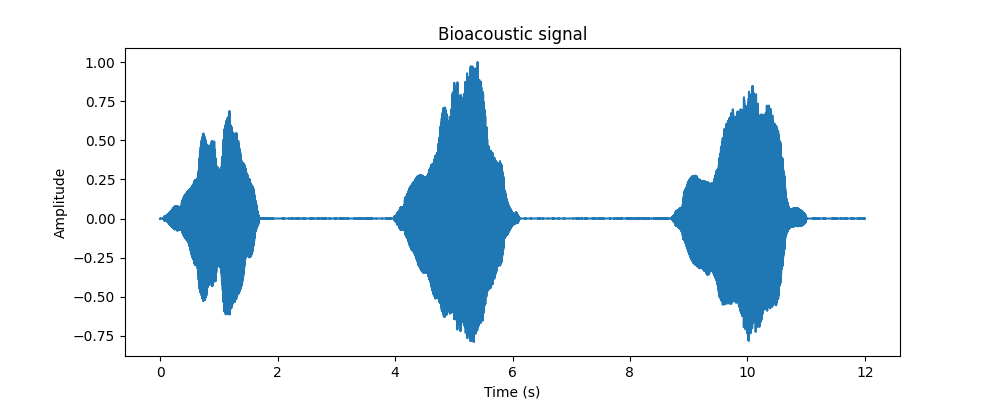

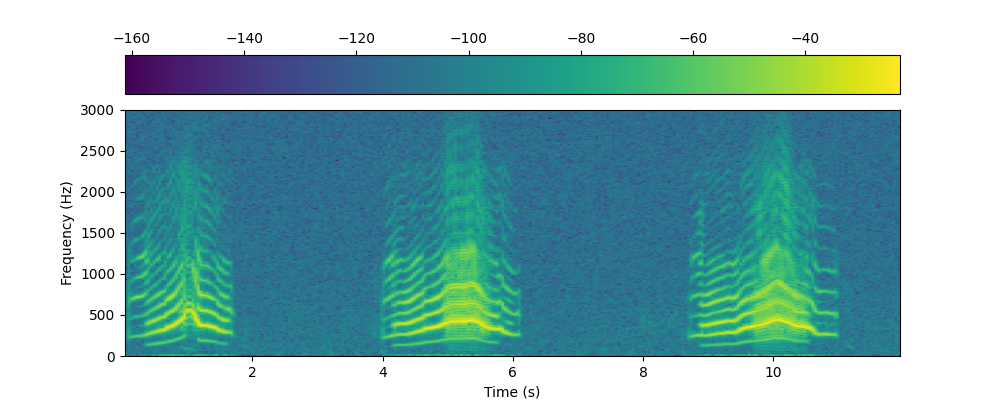

In [3]:
# Let's firstly read in an animal vocalization:
[y_raw,fs] = sf.read('./audio/a1_HT_spotted_hyenas_f0.wav') # Read in your audio file
y = y_raw[3*fs:15*fs]
y = y - np.mean(y)   # remove any offset
y = y/np.max(y)      # normalization
del y_raw
L = len(y)  # total length of the signal

t = np.arange(0,L,1)*(1/fs) # time vector


# Plotting
print("Listen:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))

# Time domain plot
fig, axes = plt.subplots(figsize=(10, 4)) 
axes.plot(t,y, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('Bioacoustic signal')

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(y, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(10, 4)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
cb = plt.colorbar(sp,ax=[axes],location='top')

In [7]:
# Function for computing the LPC coefficients over time

def LPC_analysis(x, time_seg, fs, P):

    # In this function, we will split the input signal into several time segments of a desired length and compute the LPC
    # coefficients for each of these time segments. We will also compute a Magnitude spectrum to compare the result of the all-pole filter against.

    # x - signal to analyze
    # time_seg - Length of the time segments to analyze (seconds)
    # fs - sampling freq. (Hz)
    # P - number of LPC coefficients

    # returns
    # LPC_coeff - LPC coefficients for each time segment (P x Num_seg) 
    # LPC_filt  - LPC filtered part of the signal (N x Num_seg)
    # LPC_res   - Residuals from the LPC, i.e. the difference between the true signal and the LPC model (N x Num_seg)
    # freqs     - Frequencies over which to plot the magnitude spectrum
    # Mag       - Magnitude of each time segment 
    # Num_seg   - The total number of segments analysed
    # N         - Length of time segment in samples
    
    N = int(time_seg*fs)  # Length of the time segment (samples)
    R = int(N//2)         # the step size (overlap)  
    L = len(y)            # total length of signal (samples)
    Num_seg = int(L/R)    # number of time segments
    w = np.sqrt(np.hanning(N))     # square root hanning window used for analysis and synthesis

    # These are for the magnitude spectrum of the signal in each segment.
    df = fs/N                            # freq. resolution
    freqs = np.arange(0,fs/2+df,df)      # freq. vector
    Mag = np.zeros([len(freqs),Num_seg]) # Magnitude of each time segment 

    # LPC coefficients + residuals
    LPC_coeff = np.zeros([P, Num_seg]) # a coefficients for each time segment
    LPC_filt = np.zeros([N, Num_seg])   # LPC filtered portion of signal
    LPC_res = np.zeros([N, Num_seg])   # residuals for each time segment
    
    # For loop over each segment
    for m in np.arange(0,Num_seg-1,1):
        x_seg = w*x[(0+m*R):(N + m*R)] # multiply segment with the window.

        # Get the single-sided DFT magnitude
        Y = np.fft.fft(x_seg) # FFT of Y
        Mag[:,m] = np.abs(Y[0:len(freqs)])
        
        # Setting up the equations and computing the LPC coefficients
        b = x_seg            # Signal segment
        A = np.zeros([N,P])  # Matrix previous samples
        x_col = np.concatenate([[0], x_seg[0:N-1]]) # First column of A
    
        # populate the A matrix by shifting the columns
        for p in range(P):
            x_col_shift = np.roll(x_col,p)
            x_col_shift[0:p]=0
            A[:,p] = x_col_shift
    
        a = np.linalg.lstsq(A, b)[0] # Solve system of equations, i.e. solving for the LPC coefficients 
        e = b - A@a # Residual
    
        LPC_coeff[:, m] = a
        LPC_filt[:, m] = A@a
        LPC_res[:, m] = e


    return LPC_coeff, LPC_filt, LPC_res, freqs, Mag, Num_seg, N
    


/var/folders/ng/90xk1wjn2014rw8nb9bql2200000gp/T/ipykernel_84219/682041079.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(A, b)[0] # Solve system of equations, i.e. solving for the LPC coefficients


Move the slider to see how the filter changes with time (n is the time segment).
This is the sound of the residuals at the different time instances.


interactive(children=(IntSlider(value=0, description='n', max=47), Output()), _dom_classes=('widget-interact',…

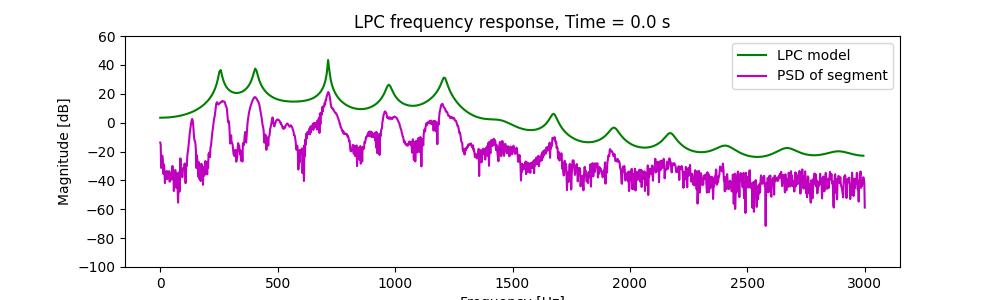

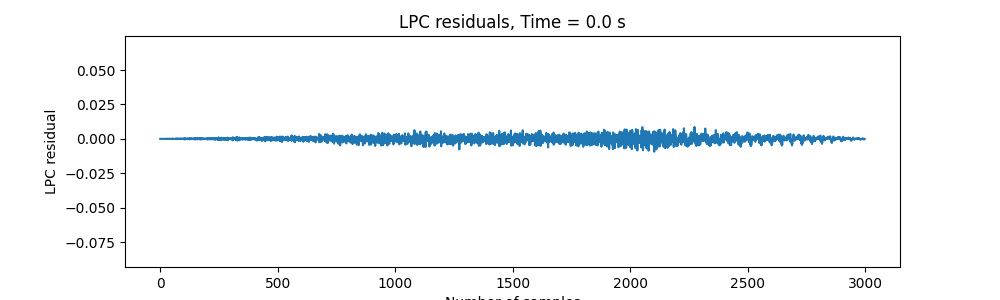

In [9]:
# Let's apply the LPC function to our signal and observe how the model changes over time.

# Run the LPC
time_seg = 0.5   # seconds
P = 30           # number of LPC coefficients
[LPC_coeff,LPC_filt,LPC_res, freqs, Mag, Num_seg, N]  = LPC_analysis(x=y, time_seg=time_seg, fs=fs, P=P)
t_timeseg = np.arange(0, Num_seg*time_seg, time_seg/2) # vector of times in terms of time segments (factor of 2 because of the overlap). Only used for plotting.

# These are the filter coefficients for the biquad filter (initialization)
b_flt =[1]
a_flt = np.concatenate([ [1], -LPC_coeff[:,0]]) # Coeff. for 1st time segment.

# Compute Mag/Phase
omega, h = signal.freqz(b_flt,a_flt)
freq_axis = omega*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots(figsize=(10, 3))
line, = ax1.plot(freq_axis, 20*np.log10(abs(h)+1e-16), 'g-', label='LPC model')
linepsd, = ax1.plot(freqs,20*np.log10(Mag[:,0]+1e-16),'m-',label='PSD of segment')
ax1.set_ylabel('Magnitude [dB]', color='k')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-100, 60])
ax1.legend()


fig, ax2 = plt.subplots(figsize=(10, 3))
line_res, = ax2.plot(LPC_res[:,0])
ax2.set_ylabel('LPC residual', color='k')
ax2.set_xlabel('Number of samples')
ax2.set_ylim([np.min(LPC_res), np.max(LPC_res)])

# fig, ax3 = plt.subplots(figsize=(10, 3))
# line_filt, = ax3.plot(LPC_filt[:,0])
# ax3.set_ylabel('LPC filtered', color='k')
# ax3.set_xlabel('Number of samples')
# ax3.set_ylim([np.min(LPC_filt), np.max(LPC_filt)])


# nfft = 512         # number of points for the FFT 
# noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# # This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# # The extent parameter is defining the corners of the image
# extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
# fig, axes = plt.subplots(figsize=(10, 4)) 
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('Frequency (Hz)')
# cb = plt.colorbar(sp,ax=[axes],location='top')


def update(n = 0):
    
    b_flt =[1]
    a_flt = np.concatenate([ [1], -LPC_coeff[:,n]]) # Coeff. for 1st time segment.

    omega, h = signal.freqz(b_flt,a_flt)

    line.set_data(freq_axis, 20 * np.log10(abs(h)+1e-16))
    linepsd.set_data(freqs,20*np.log10(Mag[:,n]+1e-16))

    line_res.set_ydata(LPC_res[:,n])
#     line_filt.set_ydata(LPC_filt[:,n])
    
    ax1.set_title('LPC frequency response, Time = '+str(np.round(t_timeseg[n],decimals=2))+ ' s')
    ax2.set_title('LPC residuals, Time = '+str(np.round(t_timeseg[n],decimals=2))+ ' s')
    # ax3.set_title('LPC filtered, Time = '+str(np.round(t_timeseg[n],decimals=2))+ ' s')


    # f_sg, t_sg, Z_mag = signal.spectrogram(LPC_res[:,n], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
    # Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB
    # sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)


    IPython.display.display(Audio(LPC_filt[:,n].T, rate=fs,normalize=True))
    # IPython.display.display(Audio(LPC_res[:,n].T, rate=fs,normalize=True))

print('Move the slider to see how the filter changes with time (n is the time segment).')
print('This is the sound of the residuals at the different time instances.')
interact(update, n = (0,Num_seg-1,1)); 

# # Time domain plot
# fig, axes = plt.subplots(figsize=(10, 4)) 
# axes.plot(t,y, label = 'Desired')
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('Amplitude')
# axes.set_title('Bioacoustic signal')

### Synthesis

What we've done so far is the "analysis" part of LPC - computing the cofficients of the linear, all-pole filter. We used this information to essentially decompose our signal into a part that represents the resonances of the signal spectral envelope and a residual component.

We can also do the inverse process, i.e. synthesis. Given the LPC coefficients, and a corresponding residual signal, we can synthesize the output signal. This allows for interesting applications of cross-synthesis, where the residual signal from the analysis of one signal can be filtered through the all-pole filter of another. I'll not explore this further, but provide a function below for synthesis. 

Below, I use this function to verify that I've done the analysis properly. If I run the residuals through the linear filters I computed in each segment, I should get back my original signal (otherwise there may have been an error somewhere).


Listen to the synthesis:


Compare with the original:


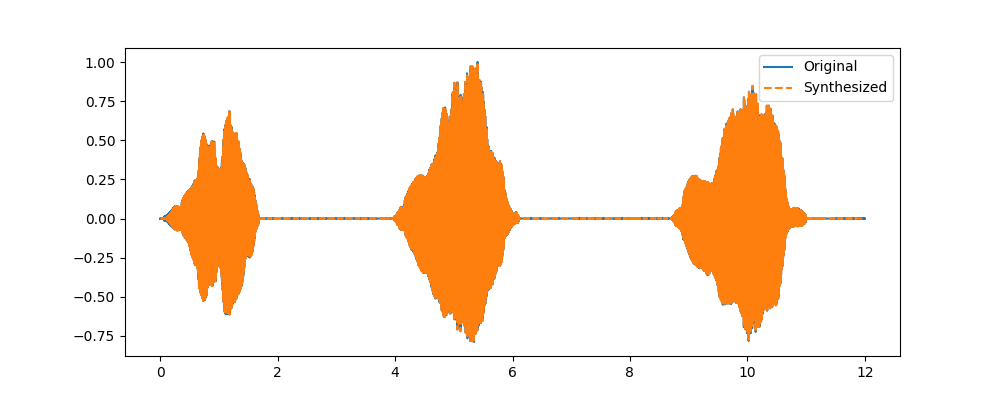

In [5]:
# The synthesis function takes the residuals and the LPC coefficients of each time frame as inputs
# In theory, one can do cross synthesis, so using the source from one signal with the LPC coefficients of another
# But one will need to firstly run the analysis first, followed by the synthesis

def LPC_synthesis(LPC_coeff, LPC_res, N):

    # LPC_coeff - LPC coefficients for each time segment (P x Num_seg) 
    # LPC_res   - Residuals from the LPC (N x Num_seg)
    # fs        - sampling freq. (Hz)
    # N         - Length of time segments in samples

    # returns
    # y_synth  - synthesized signal
    
    R = int(N//2)                  # the step size (overlap)
    w = np.sqrt(np.hanning(N))     # square root hanning window used for analysis and synthesis
    Num_seg = LPC_coeff.shape[1]
    
    y_synth = np.zeros(L) # synthesized signal

    for m in np.arange(0,Num_seg-1,1):
    
        a_flt_coeff = np.concatenate([ [1], -LPC_coeff[:,m]]) # define "a" coefficients of filter
        e_src = LPC_res[:,m]
    
        y_seg = w*(signal.lfilter(b=1, a=a_flt_coeff, x=e_src)) # filter e_src with the LPC filter and window

        # Overlap and add
        if m == 0:
            y_synth[(0+m*R):(N + m*R)] = y_seg
        else:
            y_synth[(0+m*R):(N + m*R)] = y_seg + y_synth[(0+m*R):(N + m*R)]  
        
    return y_synth

y_synth = LPC_synthesis(LPC_coeff=LPC_coeff, LPC_res=LPC_res, N=N)


# Checking to see if the original and synthesized signal is the sample
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t,y, label='Original')
ax.plot(t,y_synth,'--', label='Synthesized')
ax.legend()

print('Listen to the synthesis:')
IPython.display.display(Audio(y_synth.T, rate=fs,normalize=True))
print('Compare with the original:')
IPython.display.display(Audio(y.T, rate=fs,normalize=True))


# Uncomment to Observe the spectrogram if desired:

# # Computing the spectrogram. We use the package signal which has a spectrogram function
# nfft = 512         # number of points for the FFT 
# noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# # Compute the spectrogram. We set the mode to obtain the magnitude, 
# # i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# # Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
# f_sg, t_sg, Z_mag = signal.spectrogram(y_synth, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
# Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# # This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# # The extent parameter is defining the corners of the image
# extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
# fig, axes = plt.subplots(figsize=(10, 4)) 
# sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('Frequency (Hz)')
# cb = plt.colorbar(sp,ax=[axes],location='top')

### References:

1. Vaseghi, S.V. (2008). Linear Prediction Models. In Advanced Digital Signal Processing and Noise Reduction, S.V. Vaseghi (Ed.). https://doi.org/10.1002/9780470740156.ch8

2. Hyung-Suk Kim, Linear Predictive Coding is All-Pole Resonance Modeling, https://ccrma.stanford.edu/~hskim08/lpc/
   
